In [ ]:
!nvidia-smi

# Installs

In [ ]:
!pip install -q -U git+https://github.com/albumentations-team/albumentations
!pip install -q "torch==1.4" "torchvision==0.5.0"
!pip install -q torch_optimizer
!pip install -q ensemble-boxes
!pip install -q timm
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch
!pip install -q effdet
!pip install -q omegaconf
!pip install -q effdet omegaconf
!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d5-ef44aea8.pth

# Imports

In [2]:
import os
import cv2
import glob
import copy 
import torch
import effdet
import random
import torchvision 
import numpy as np
import pandas as pd
import imgaug as ia
%matplotlib inline
from numba import jit
import albumentations as A
from tqdm.auto import tqdm
import torch.optim as optim
from ensemble_boxes import *
from google.colab import drive
import torch_optimizer as optim1
from torchvision import transforms
from imgaug import augmenters as iaa
from matplotlib import pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler 
from torch.utils.data import Dataset,DataLoader
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet

SEED = 44

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

drive.mount('/content/gdrive')


cuda:0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Constants

In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 2

## Path define 

In [4]:
train = pd.read_csv("/content/gdrive/My Drive/Global Wheat Detection/train.csv") 
train_path = "/content/gdrive/My Drive/Global Wheat Detection/train"
checkpoints_path= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/efficient -D7- new try"

In [5]:
train.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
bboxes = np.stack(train['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x_min', 'y_min', 'width', 'height']):
    train[column] = bboxes[:,i]

# bboxes = np.stack(train['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
# for i, column in enumerate(['x', 'y', 'w', 'h']):
#     train[column] = bboxes[:,i]
    
# train["x_max"] = train.apply(lambda col: col.x_min + col.width, axis=1)
# train["y_max"] = train.apply(lambda col: col.y_min + col.height, axis = 1)
train.drop(columns=['bbox'], inplace=True)
train.drop(columns=['source'], inplace=True)

In [7]:
train.head(5)

,image_id,width,height,x_min,y_min
0,b6ab77fd7,56.0,36.0,834.0,222.0
1,b6ab77fd7,130.0,58.0,226.0,548.0
2,b6ab77fd7,74.0,160.0,377.0,504.0
3,b6ab77fd7,109.0,107.0,834.0,95.0
4,b6ab77fd7,124.0,117.0,26.0,144.0


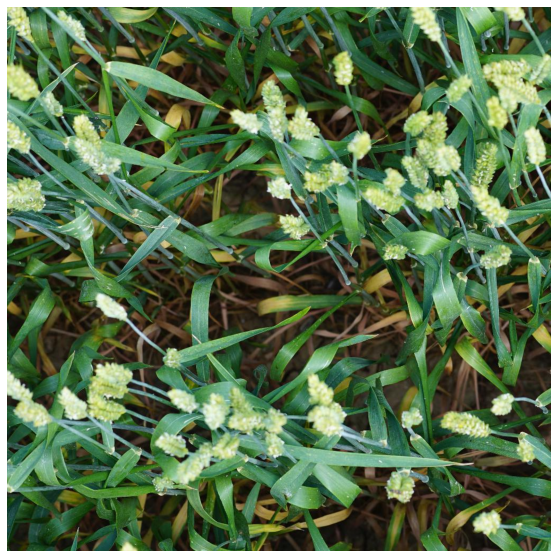

In [8]:
image_id = 'c14c1e300'
image = cv2.imread(f'{train_path}/{image_id}.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.figure(figsize = (10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()



---

# Defining The Dataset class

[https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-your-model](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-your-model)



1. **image**: image of size (H, W)
2. **target**: a dict containing the following fields: 
* **boxes** : the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, 
ranging from 0 to W and 0 to H
* **labels** : the label for each bounding box. 0 represents always the background class.
* **image_id** : an image identifier. It should be unique between all the images in the dataset, and is used during evaluation

3.CutMix Augmantation - explained in the preprocessing notebbok
* The implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
* Refactoring and adaptation: https://www.kaggle.com/shonenkov



---


```
target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  

```
In the library of EffDet they use yxyx format, so in order to train our model we need the boxe format tu be the same. 

---




In [9]:
class WheatDetectionDataset(Dataset):
    def __init__(self, dataframe, image_dir, image_ids, transforms=None, test=False):
        super().__init__()
        self.image_ids = image_ids
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]

        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
      
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(20):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                assert len(sample['bboxes']) == labels.shape[0], 'not equal!'

                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    #yxyx:
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  
                    break
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
     
     
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = records[['x_min', 'y_min', 'width', 'height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] #PASCAL-VOC
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] 
        # add coco
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

# Augmentations -  were explained in the Preprocessing notebook 
[Pre-Processing NoteBook](https://colab.research.google.com/drive/1SFHLFbjzvcrzVzbBC8pTHxsXw6dzKq0-#scrollTo=TJpYX7kY61VW)





In [10]:
def make_augmantations(p = 1): #TODOO
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.2),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.6),
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
            A.Cutout(num_holes=8, max_h_size=20, max_w_size=20, p=0.8),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def make_augmantations_val(p = 1): 
    return A.Compose(
        [
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


# DataLoader -

We found that the shuffle the data before spliting it to test and train, gives better results, we think that its helped because the images arranged in some order where the validation part knows only small amount of types of the images.

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

random.shuffle(list(train['image_id'].unique()))
train_data, val_data = train_test_split(train['image_id'].unique(), test_size = 0.1, random_state = 2018) #train_val split using sklearn

train_transforms = make_augmantations()
val_transforms = make_augmantations_val()

train_set = WheatDetectionDataset(train, train_path, train_data, transforms = train_transforms, test= False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, pin_memory=False, drop_last=True, num_workers = 2 , collate_fn = collate_fn)

val_set = WheatDetectionDataset(train, train_path , val_data, transforms = val_transforms, test = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, shuffle=False, pin_memory=False, num_workers = 2 , collate_fn = collate_fn)

In [12]:
def norm(img):
    img -=img.min()
    img/=img.max()
    return img

### Load few images with the data loader to show them

In [25]:
batch = iter(train_loader)
imgs, labls, img_id = next(batch)
images = list(img.to(device) for img in imgs)
labels = [{k: v.to(device) for k, v in t.items()} for t in labls]

# Vizualization - Display Boxes On Images

In [13]:
def print_boxes(images, labels,threshold=None):
  plt.figure(figsize=[25, 20])
  for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i+1)
    boxes = label['boxes']
    scores=None
    if 'scores' in label.keys():
      scores=label['scores']
    sample = img.permute(1,2,0).cpu().numpy()
    sample = sample*255.0
    for j in range(len(boxes)):
      box=boxes[j]
      active=True

      if scores is not None: 
        score=str(float("{:.3f}".format(scores[j])))
        if threshold is not None and float(score)<threshold:
          active=False
      else:
        score=''
      
      if active:
        cv2.rectangle(sample,
                    (box[1], box[0]),
                    (box[3], box[2]),
                    (255, 0, 0), 2)
        
        cv2.putText(
          sample,
          score,
          org=(int(box[0]), int(box[1] )), # bottom left
          fontFace=cv2.FONT_HERSHEY_PLAIN,
          fontScale=1.5,
          color=(255,0, 0),
          thickness=2
        )

      plt.imshow(sample.astype(np.uint8))    
    plt.axis('off')
  plt.show()


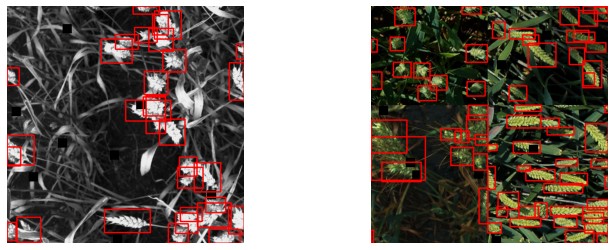

In [27]:
print_boxes(images,labels)

# EfficentDet Model Creation - 

[https://towardsdatascience.com/googles-efficientdet-an-overview-8d010fa15860](https://towardsdatascience.com/googles-efficientdet-an-overview-8d010fa15860)


---

With the invention of the BiFPN, a new family of detectors has been created called EfficientDet. The architecture of EfficientDet is shown below and uses the EfficientNet as a backbone network.

EfficientNet PyTorch is a PyTorch re-implementation of EfficientNet. It is consistent with the original TensorFlow implementation, such that it is easy to load weights from a TensorFlow checkpoint. At the same time, we aim to make our PyTorch implementation as simple, flexible, and extensible as possible.


---
There are 8 differenet models D0-D7 for efficientDet model where each one of them have different arichtecture, where D0 is the smallest model and D7 is the largest one. 

[papaer about efficientDet](https://openaccess.thecvf.com/content_CVPR_2020/papers/Tan_EfficientDet_Scalable_and_Efficient_Object_Detection_CVPR_2020_paper.pdf)

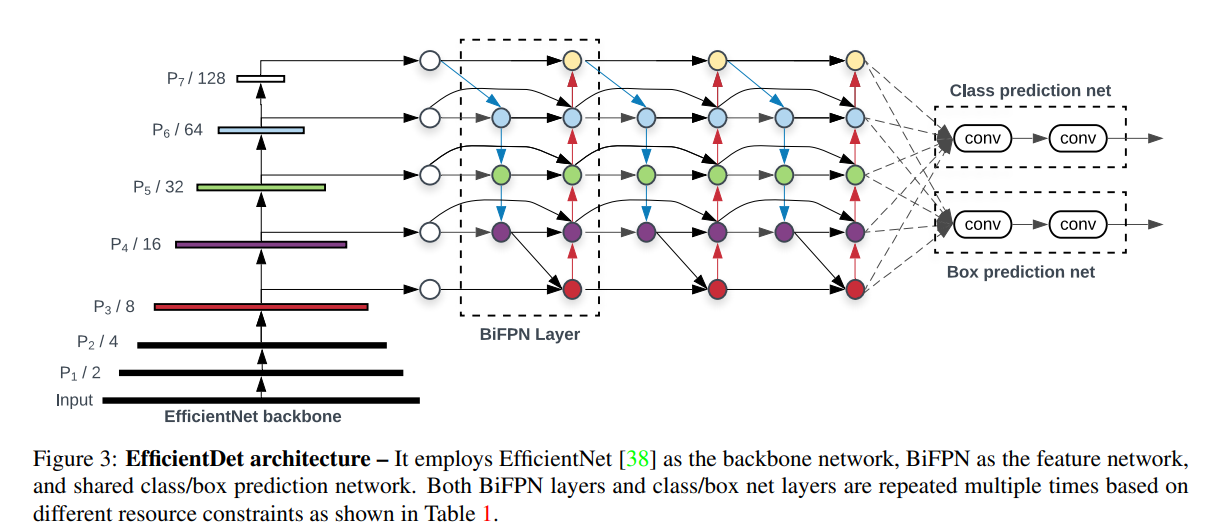

![effdet performance](https://miro.medium.com/max/1000/1*xw-1j5Q0bGlmr1lYo1pWqw.png
)
 

---

We chose to use this model, because we saw the scores and results on kaggle, and saw that people who used this models get higher and better scores, so we tried to improve our score after trying FasterRCNN and really saw that our results improved but not much.
we used D5 and D7 models which gave us nice results, D7 gave better results than d5.

## Load model - 


---

while trying to load to model we ran into problems. beacuse we used the kaggle libreries on colab, and realized that they not updated, and the input of the model is now different. after we investigate the issue we realized that the libreries was updated and now getting other parameters as an input on 
1. Train() mode :
 * image
 * target
2. and on Eval() mode :
* image
* image size
* image scale

3. As well we realized that detBenchEval() were updated to detBenchPredict().

After we understood all those problems and solved them we implemented the training and evaluation methods.

In [14]:
config = get_efficientdet_config('tf_efficientdet_d5')
# config = get_efficientdet_config('tf_efficientdet_d7')
model = EfficientDet(config, pretrained_backbone=True)
config.num_classes = 1
config.image_size = 512
model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
model = DetBenchTrain(model, config)

# Optimizers

---


we tried and trained our model with all the optimizers below, and found that adamw worked the best for us and gave the best result, of course after finding the right pararmeters of the LR.

 

*   **Adam** - this method considered as a method of Stochastic Optimization is a technique implementing adaptive learning rate. Under normal SGD the learning rate has an equivalent type of effect for all the weights / parameters of the model.Parameters that would ordinarily receive smaller or less frequent updates receive larger updates with Adam (the reverse is also true).

[Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)


*   **Radam** - is a new variation of adam oprimizer, much less sensetive to chosen learning rates, and better accuracy.RAdam provides a dynamic heuristic to provide automated variance reduction and thus removes the need and manual tuning involved with a warmup during training.

learning rate. [Radam](https://arxiv.org/pdf/1908.03265.pdf)


*   **Adamw** - Adam optimizer with Decoupled Weight Decay Regularization.


![alt text](https://www.fast.ai/images/adamw_charts.png)

*   **SGD** - the difference from GD, is that instead of of run all the samples in the training set and do a single update in a particulaar iteration, in SGD we use only one training sample from the training set to do the update. using SGD will be faster cause we use only one training sample, but the error is bigger than in the case of GD.



![alt text](https://miro.medium.com/max/3850/1*BMwu8Km-CtPsvaH8OM5_-g.jpeg)


In [15]:
import torch.optim as optim
import torch_optimizer as optim1
import torch.optim.lr_scheduler as lr_scheduler 

In [16]:
def optimizers(params, option , lr = 1e-4, weight_decay=0): 
    if option == 'adamw':
        optimizer = optim.AdamW(params, lr=lr, weight_decay= weight_decay)
    if option == 'adam':
        optimizer = optim.Adam(params, lr = lr , weight_decay=weight_decay)
    if option == 'radam':
        optimizer = optim1.RAdam(params, lr =lr,  weight_decay=weight_decay)
    if option == 'sgd':
        optimizer = optim.SGD(params, lr= lr)
    return optimizer


# Training Loop + Valdiation 

In [21]:
def get_last_checkpoint(path):
    cp_path = glob.glob(f'{path}/*.pt')
    if len(cp_path) == 0 :
        return None
    return cp_path[np.argmax([int(x.split("/")[-1][2:].split(".")[0]) for x in cp_path])]

In [17]:
def train_one_epoch_efficient(data_loader_train, model, optimizer, total, r_loss, train_loss):
    target_res= {}
    for i, (images, targets, img_id) in enumerate(tqdm(data_loader_train, desc = "train")):
        images = torch.stack(images)
        images = images.to(device).float()
        batch_size = images.shape[0]
        boxes = [target['boxes'].to(device).float() for target in targets]
        labels = [target['labels'].to(device).float() for target in targets]
        target_res['bbox'] = boxes
        target_res['cls'] = labels    
        optimizer.zero_grad()
        loss_dict = model(images, target_res)
        losses = loss_dict['loss']
        total += len(labels)
        r_loss+= losses.item() * len(labels)
        losses.backward()  
        optimizer.step() 
    train_loss = r_loss / total
    return train_loss, r_loss, total

In [18]:
def evaluation_efficient(data_loader_val, model, total, r_loss, val_loss):
    target_res= {}
    with torch.no_grad():
        for idx, (images_val, labels_val, img_id_val) in enumerate(data_loader_val, 0):
            images_val = torch.stack(images_val)
            images_val = images_val.to(device).float()            
            boxes_val = [target['boxes'].to(device).float() for target in labels_val]
            labels_val = [target['labels'].to(device).float() for target in labels_val]
            target_res['bbox'] = boxes_val
            target_res['cls'] = labels_val    
            loss_dict = model(images_val, target_res)
            losses = loss_dict['loss']
            r_loss += losses.item() * len(labels_val)
            total += len(labels_val)
    val_loss = r_loss / total
    return val_loss, r_loss, total

In [19]:
def training_loop_efficient(data_loader_train, data_loader_val ,model, optimizer, scheduler, cp_path = None, num_of_epochs = 20):
    loss_list = list()
    loss_list_val = list()
    model.to(device)  
    loss_dict = {}
    epoch = 0

    if cp_path is not None:       
        checkpoint = torch.load(cp_path)
        model.model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss_train = checkpoint['loss_train']
        loss_val = checkpoint['loss_val']
    
    print(epoch)
    try:   
        for e in tqdm(range(epoch + 1, num_of_epochs)):
            model.train()
            train_loss = 0
            val_loss = 0
            r_loss = 0
            total = 0   
            train_loss, r_loss, total = train_one_epoch_efficient(data_loader_train, model, optimizer, total, r_loss, train_loss)
            loss_list.append(train_loss) 
            r_loss = 0
            total = 0   
            val_loss, r_loss, total = evaluation_efficient(data_loader_val, model, total, r_loss, val_loss)
            print('Validation:[%d, %5d] train_loss: %.15f' %(e, num_of_epochs, train_loss))
            print('Validation:[%d, %5d] val_loss: %.15f' %(e, num_of_epochs, val_loss))
            loss_list_val.append(val_loss)
            scheduler.step(metrics=val_loss)
            torch.save({
                        'epoch': e,
                        'model_state_dict': model.model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss_train': loss_list,
                        'loss_val': loss_list_val,
                        }, f'{checkpoints_path}/cp{e}.pt')
    except RuntimeError as e:
        print(e)
    except KeyError as e:
        print(e)
    except TypeError as e:
        print(e)
    except KeyboardInterrupt as e:
        print(e)
    finally:
        torch.cuda.empty_cache()
    return loss_list, loss_list_val, model.cpu()

# Scheduler(ReduceLROnPlateau) -
Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

we used this scheduler which we saw in many notebooks that helping for the training, and after use it we saw that it really does. 


---
* `factor`: factor by which the learning rate will be reduced. new_lr = lr * factor.
* `patience`: number of epochs with no improvement after which learning rate will be reduced.
* `verbose`: int. 0: quiet, 1: update messages.
* `mode`: one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
* `cooldown`: number of epochs to wait before resuming normal operation after lr has been reduced.
* `min_lr`: lower bound on the learning rate.




In [22]:
optimizer = optimizers(model.parameters(),'adam', lr = 2e-3, weight_decay=1e-5)
# optim = optimizers(model.parameters(),'sgd', lr = 1e-3)
# optimizer = optimizers(model.parameters(),'adamw', lr = 1e-5)
# scheduler = lr_scheduler.StepLR(optim, step_size=9, gamma=0.1)  

scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)
  
cp_path = get_last_checkpoint(checkpoints_path)
loss_list1, val_loss_list, best_model = training_loop_efficient(train_loader, val_loader, model, optimizer, scheduler, cp_path = cp_path , num_of_epochs = 11)

12


# Plot the Graph Of the Training - 

---
This graph has only 12 epochs just to demonstarte the convergence of the loss. we trained our models on 20-60 epochs.

---


We saved checkpoints of our model while training, and it was very comfortable for us, and removed worries about internet problems or 'cuda out of memory' problems, and we could conect to the drive from any account and load the checkpount from the point its stopped.


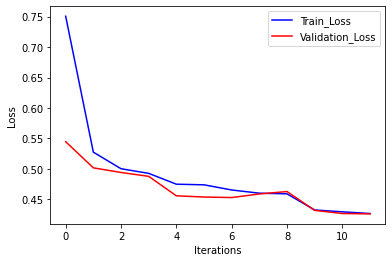

In [27]:
# plt.plot(loss_list1, 'b')
# plt.plot(val_loss_list, 'r')
# plt.legend(('Train_Loss', 'Validation_Loss'), loc='upper right')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.show()


# Understanding Evaluation Metrics


---

This competition is evaluated on the **mean average precision** at different intersection over union (IoU) thresholds.
 
To understand mAP, we will explain about precision and recall first.
* Recall is the True Positive Rate i.e. Of all the actual positives, how many are True positives predictions. 
* Precision is the Positive prediction value i.e. Of all the positive predictions, how many are True positives predictions. Read more in evaluation metrics for classification.



---
## mAP 

**mAP (mean average precision)** is the average of AP. In some context, we compute the AP for each class and average them. But in some context, they mean the same thing. For example, under the COCO context, there is no difference between AP and mAP.

# Evaluate AR + AP
Evaluate AR for object proposals, AP for instance detection/segmentation, AP for keypoint detection outputs using COCO's metrics

AP (Average precision) is a popular metric in measuring the accuracy of object detectors like Faster R-CNN, SSD, etc. Average precision computes the average precision value for recall value over 0 to 1.


![alt text](https://i.stack.imgur.com/JlHnn.jpg)

# Intersection over Union (IoU)

---


Intersection over Union is a measure of the magnitude of overlap between two bounding boxes (or, in the more general case, two objects). It calculates the size of the overlap between two objects, divided by the total area of the two objects combined.

The two boxes in the visualization overlap, but the area of the overlap is insubstantial compared with the area taken up by both objects together. IoU would be low - and would likely not count as a "hit" at higher IoU thresholds.

![alt text](https://storage.googleapis.com/kaggle-media/competitions/rsna/IoU.jpg)

In [23]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float: ###TODO
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area
    
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'pascal_voc', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'pascal_voc') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

#Display prediction ov validation

In [24]:
config = get_efficientdet_config('tf_efficientdet_d5')
model = EfficientDet(config, pretrained_backbone=False)

config.num_classes = 1
config.image_size=512
model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
checkpoint = torch.load('/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/d5 -אימון 4/cp25.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model = DetBenchPredict(model, config)
model.to(device)
model.eval();


In [91]:
batch = iter(train_loader)
imgs, labls, img_id = next(batch)

In [113]:
import matplotlib.pyplot as plt
model.eval()

for j, (images,targets ,image_ids) in enumerate(val_loader):
    break
try:
    images = torch.stack(images).cuda().float()
    x = torch.tensor([1.0] * 4, dtype=torch.float).to(device)
    y = torch.tensor([images[0].shape[-2:]] * 4, dtype=torch.float).to(device)
    out = model.forward(images,img_size=y,img_scales=x)
    
    
except Exception as e:
    print(e)
finally:
    torch.cuda.empty_cache()

# Show Predicitions

In [118]:
det =out[0]
predictions = []
boxes = det.detach().cpu().numpy()[:,:4]    
scores = det.detach().cpu().numpy()[:,4]
indexes = np.where(scores > 0.3)[0]
boxes = boxes[indexes]
boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
predictions.append({
    'boxes': boxes[indexes],
    'scores': scores[indexes],})

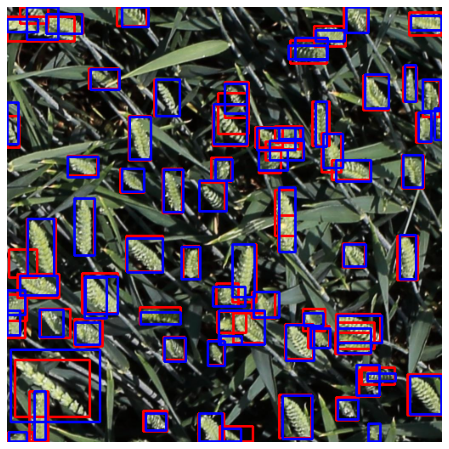

In [119]:
sample = images[0].permute(1,2,0).cpu().numpy()

boxes = predictions[0]['boxes'].astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2) #red

boxes = targets[0]['boxes'].numpy().astype(np.int32).clip(min=0, max=511) 
for box in boxes:
    cv2.rectangle(sample, (box[1], box[0]), (box[3], box[2]), (0, 0, 1), 2) #blue  
ax.set_axis_off()
ax.imshow(sample);

In [125]:
def print_boxes(images, labels, threshold=None, pred = False):
  plt.figure(figsize=[30, 30])
  for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i+1)
    boxes = label['boxes']
    scores=None
    if 'scores' in label.keys():
      scores=label['scores']
    sample = img.permute(1,2,0).cpu().numpy()
    sample = sample*255.0
    for j in range(len(boxes)):
      box = boxes[j]
      active=True

      if scores is not None: 
        score=str(float("{:.3f}".format(scores[j])))
        if threshold is not None and float(score)<threshold:
          active=False
      else:
        score=''
      if pred:
        active = False
        cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (255, 0, 0), 2)
        
        cv2.putText(
        sample,
        score,
        org=(int(box[0]), int(box[1] )), # bottom left
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.5,
        color=(255,0, 0),
        thickness=2
        )

      if active:
        cv2.rectangle(sample,
                    (box[1], box[0]),
                    (box[3], box[2]),
                    (255, 0, 0), 2)
        
        cv2.putText(
          sample,
          score,
          org=(int(box[0]), int(box[1] )), # bottom left
          fontFace=cv2.FONT_HERSHEY_PLAIN,
          fontScale=1.5,
          color=(255,0, 0),
          thickness=2
        )
        
      plt.imshow(sample.astype(np.uint8))    
    plt.axis('off')
  plt.show()


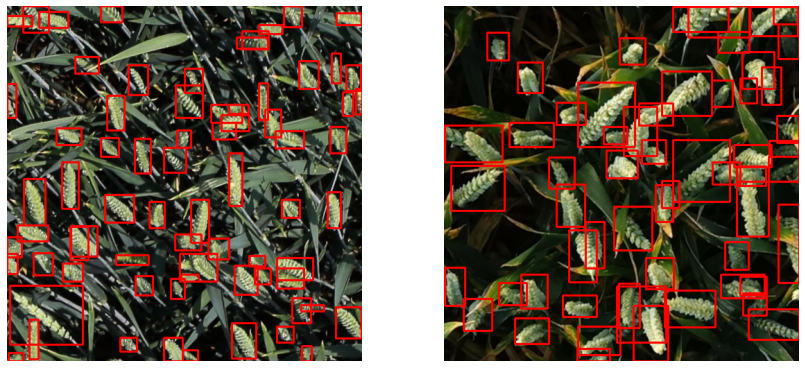

In [126]:
print_boxes(images, targets) 

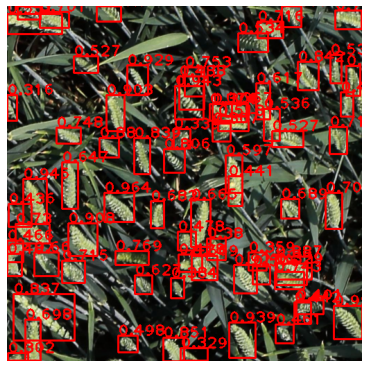

In [127]:
print_boxes(images, predictions, pred = True) 

# print IOU model

In [128]:

validation_image_precisions = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
model.to(device)
model.eval()

# try:
for images, targets, _ in val_loader:
    images = torch.stack(images).cuda().float()
    x = torch.tensor([1.0] * 2, dtype=torch.float).to(device)
    y = torch.tensor([images[0].shape[-2:]] * 2 , dtype=torch.float).to(device)
    torch.cuda.empty_cache()
    out = model.forward(images, img_size=y, img_scales=x)

    for output, target in zip(out, targets):
        boxes = output.cpu().detach().numpy()[:,:4]
        scores = output.cpu().detach().numpy()[:,4]
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]  
        boxes[:,[1,0,3,2]] = boxes[:,[0,1,2,3]] 
        # boxes[:, 2] = boxes[:, 2] - boxes[:, 0]# w = xman-xmin
        # boxes[:, 3] = boxes[:, 3] - boxes[:, 1]# h = yman-ymin
        gt_boxes = target['boxes'].detach().numpy()


        preds_sorted_idx = np.argsort(scores)[::-1]  
       
        preds_sorted = boxes[preds_sorted_idx]

      
    # for idx, image in enumerate(images):
        image_precision = calculate_image_precision(gt_boxes, preds_sorted, thresholds=iou_thresholds,form='coco')

        validation_image_precisions.append(image_precision)

print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))
# except Exception as e:
#     print(e)
#     torch.cuda.empty_cache()
# except RuntimeError as e:
#     print(e)
# except KeyError as e:
#     print(e)
# except TypeError as e:
#     print(e)
# except KeyboardInterrupt as e:
#     print(e)
    

/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'thresholds' of function 'calculate_image_precision'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-39-efa771cbfb4b>", line 131:
@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'pascal_voc') -> float:
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'thresholds' of function 'calculate_image_precision'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-r

Validation IOU: 0.4148


#TEST Dataset

In [71]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [72]:
DATA_ROOT_PATH = "/content/gdrive/My Drive/Global Wheat Detection/test"

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

## DataSet + Data_loader

In [74]:
dataset = DatasetRetriever(np.array([path.split('/')[-1][:-4] for path in glob.glob(f'{DATA_ROOT_PATH}/*.jpg')]),get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

# Create submission format

In [75]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [76]:
batch = iter(data_loader)
imgs,img_id = next(batch)

In [77]:
results = []
model.eval()
model.to(device)
images = torch.stack(imgs).cuda().float()
x = torch.tensor([1.0] * 4, dtype=torch.float).to(device)
y = torch.tensor([images[0].shape[-2:]] * 4, dtype=torch.float).to(device)
predictions = model.forward(images, img_size=y, img_scales=x)

## Submission without wbf

In [78]:
results = []
model.eval()
model.to(device)
for imgs, image_ids in data_loader:
    images = torch.stack(imgs).cuda().float()
    x = torch.tensor([1.0] * 4, dtype=torch.float).to(device)
    y = torch.tensor([images[0].shape[-2:]] * 4, dtype=torch.float).to(device)
    predictions = model.forward(images, img_size=y, img_scales=x)
    for i, pred in enumerate(predictions):
        boxes = pred.cpu().detach().numpy()[:,:4]
        scores = pred.cpu().detach().numpy()[:,4]
      
        boxes = (boxes*(2)).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        indexes = np.where(scores > 0.3)[0]
        boxes = boxes[indexes]
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0] # xmax
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1] # ymin
        # boxes[:,[1,0,3,2]] = boxes[:,[0,1,2,3]] 

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        sample = images[i].permute(1,2,0).cpu().numpy()
        sample = cv2.resize(sample, (1024,1024))
        for j,box in enumerate(boxes):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
            score=str(float("{:.3f}".format(scores[j])))

            cv2.putText(
                      sample,
                      score,
                      org=(int(box[0]), int(box[1] )), # bottom left
                      fontFace=cv2.FONT_HERSHEY_PLAIN,
                      fontScale=3,
                      color=(255,0, 0),
                      thickness=2
                    )
        ax.set_axis_off()
        ax.imshow(sample)


        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

Output hidden; open in https://colab.research.google.com to view.

In [79]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head(10)

,image_id,PredictionString
0,348a992bb,0.9132 737 226 136 83 0.8406 4 320 112 92 0.83...
1,51b3e36ab,0.8961 465 16 79 137 0.8533 2 916 82 105 0.839...
2,2fd875eaa,0.9097 391 794 78 93 0.9093 460 499 81 133 0.8...
3,aac893a91,0.8184 558 535 121 183 0.8009 21 450 113 160 0...
4,cb8d261a3,0.8887 755 713 80 83 0.8760 23 866 77 142 0.82...
5,cc3532ff6,0.9109 775 831 157 154 0.8766 100 612 80 141 0...
6,796707dd7,0.7441 711 827 103 97 0.7407 895 336 107 87 0....
7,f5a1f0358,0.8570 448 308 96 178 0.8025 887 646 84 139 0....
8,51f1be19e,0.7575 609 88 149 164 0.6290 652 788 97 83 0.5...
9,53f253011,0.8796 790 637 103 102 0.8678 622 106 115 141 ...


# WBF over TTA


---




## TTA

---

### What is Test Time Augmentation ?
Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.

[https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d](https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d)

![alt text](https://preview.ibb.co/kH61v0/pipeline.png)

In [80]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = IMAGE_SIZE

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [81]:
from ensemble_boxes import *


## WBF
---


Suppose we have several different models and predictions for each of them.
Such case is often used in practice, when the predictions
are additionally obtained from a vertically reflected image.
The question arises whether it is possible to combine predictions in such a way that the quality of predictions for a
given metric improves. The answer to this question is yes.
For this, NMS (Non-maximum Suppression) method and
its Soft-NMS extension are often used, which give good
results. In the [paper](https://arxiv.org/pdf/1910.13302.pdf) they propose a new Weighted Boxes Fusion (WBF) method that allows you to combine the predictions of various Object Detection models. Unlike the above
methods, which simply remove part of the predictions, the
proposed method uses all the predicted rectangles, which can significantly improve the quality of the combined rectangles


![alt text](https://i.ibb.co/d2P2pPL/2020-05-12-21-02-34.png)

In [89]:
def make_tta_predictions(images, score_threshold=0.35):
  model.eval()
  model.to(device)
  with torch.no_grad():
      images = torch.stack(images).float().cuda()
      predictions = []
      for tta_transform in tta_transforms:
          result = []
          x = torch.tensor([1.0] * 2, dtype=torch.float).to(device)
          y = torch.tensor([images[0].shape[-2:]] * 2 , dtype=torch.float).to(device)
          det = model(tta_transform.batch_augment(images.clone()),img_size=y, img_scales=x)

          for i in range(images.shape[0]):
              boxes = det.cpu().detach().numpy()[:,:4]
              scores = det.cpu().detach().numpy()[:,4]
              indexes = np.where(scores > score_threshold)[0]
              boxes = boxes[indexes]
            #   boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            #   boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
              boxes = tta_transform.deaugment_boxes(boxes.copy())
              result.append({
                  'boxes': boxes,
                  'scores': scores[indexes],
              })
          predictions.append(result)
  return predictions



# def run_wbf(predictions, image_index, image_size=512, iou_thr=0.4, skip_box_thr=0.3,score_threshold= 0.3, weights=None):
#     boxes = [(prediction[image_index]['boxes']/(image_size)).tolist() for prediction in predictions]
#     scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
#     labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
#     boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
#     indexes = np.where(scores > score_threshold)[0]
#     boxes = boxes[indexes]    
#     scores = scores[indexes]
#     boxes = boxes*(image_size)
#     return boxes, scores, labels

def run_wbf(predictions, image_index, image_size=IMAGE_SIZE, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size)
    return boxes, scores, labels

In [ ]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), TTARotate180(), TTARotate270(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

validation_image_precisions = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
model.eval()
model.to(device)

for images, targets, _ in tqdm(val_loader):
    predictions = make_tta_predictions(images)
    for i,img in enumerate(range(len(images))):
        # sample = images[i].permute(1,2,0).cpu().numpy()
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.round().astype(np.int32).clip(min=0, max=IMAGE_SIZE-1)
        # images = list(img.to(device) for img in images)
        # outputs = model(images)
        # for output, target in zip(outputs, targets):
        #     preds = output['boxes'].cpu().detach().numpy()
        #     scores = output['scores'].cpu().detach().numpy()
        gt_boxes = targets[i]['boxes'].detach().numpy()
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = boxes[preds_sorted_idx]

        # # for idx, image in enumerate(images):
        image_precision = calculate_image_precision(preds_sorted,
                                                    gt_boxes,
                                                    thresholds=iou_thresholds,
                                                    form='pascal_voc')

        validation_image_precisions.append(image_precision)

print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

## Submission with wbf +tta

In [ ]:
results = []
model.eval()
model.to(device)
for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0] # xmax
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1] # ymin
        boxes[:,[1,0,3,2]] = boxes[:,[0,1,2,3]] 

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        sample = images[i].permute(1,2,0).cpu().numpy()
        sample = cv2.resize(sample, (1024,1024))
        for j,box in enumerate(boxes):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
            score=str(float("{:.3f}".format(scores[j])))

            cv2.putText(
                      sample,
                      score,
                      org=(int(box[0]), int(box[1] )), # bottom left
                      fontFace=cv2.FONT_HERSHEY_PLAIN,
                      fontScale=3,
                      color=(255,0, 0),
                      thickness=2
                    )
        ax.set_axis_off()
        ax.imshow(sample)
        
    
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [ ]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), TTARotate180(), TTARotate270(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

validation_image_precisions = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
model.eval()
model.to(device)

results = []
    
for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i,img in enumerate(images):
        # sample = images[i].permute(1,2,0).cpu().numpy()
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes_s = (boxes*(2)).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes_s[:, 2] = boxes_s[:, 2] - boxes_s[:, 0]
        boxes_s[:, 3] = boxes_s[:, 3] - boxes_s[:, 1]


        result = {
          'image_id': image_id,
          'PredictionString': format_prediction_string(boxes_s,scores)
        }
        results.append(result)  


In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head(10)

In [ ]:
for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i,image_size=IMAGE_SIZE)
boxes = boxes.round().astype(np.int32).clip(min=0, max=IMAGE_SIZE-1)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);